# Conclusions

We now have a production model and some final data to explore, let's draw some conclusions about whether we can tell these audiences apart

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from my_functions import tokenize_and_stem
%store -r processed_sw

In [200]:
sorted_proba = pd.read_csv('./data/prod_model_sorted_probas.csv', index_col='Unnamed: 0')
predictions = pd.read_csv('./data/prod_model_predictions.csv', index_col='Unnamed: 0')
word_importance = pd.read_csv('./data/word_importance.csv', index_col='Unnamed: 0')

Now that we've done our modeling, we can take a look at how our model is handling the data. Let's look at the words that our model considers to have high predictive power for both subreddits:

In [94]:
# Let's find the posts our model determined to most likely NOT belong to the PopPunkers Subreddit:
sorted_proba.head(5)

,poppunkers,punk,orig_post
1047,2.507803e-194,1.0,There’s tons of styles of punk that never get ...
1004,3.148095e-129,1.0,After crying to Never Meant and some midwester...
915,8.555036e-117,1.0,[The A.G.'s - Hurt a Cop](https://www.youtube....
83,1.106610e-85,1.0,"Hey everyone, we've been getting a lot of comp..."
201,9.947772e-80,1.0,"Hardcore is more than music. Its a cliche, but..."


In [95]:
# Now the same thing here, but for Punk
sorted_proba.sort_values(by='punk').head()

,poppunkers,punk,orig_post
2492,1.0,0.000000e+00,"So a few days ago, I saw an article that was a..."
2362,1.0,3.930880e-111,https://preview.redd.it/58uid2966a651.jpg?widt...
3350,1.0,4.149074e-97,# Albums\n\n[Beach Bunny - Honeymoon](https://...
2935,1.0,2.688677e-88,The bands that made the cut...\n\n1. All Time ...
1928,1.0,1.337815e-82,Hello all! I'm trying to create a succinct tim...


Let's see what words were used most in the top 100 posts that our model determined to be **most likely** a part of one subreddit or the other

In [178]:
def top_20_words(data):
    # And let's run these posts through CountVectorizer
    cvec = CountVectorizer(tokenizer=tokenize_and_stem, stop_words=processed_sw)
    cvec_data = cvec.fit_transform(data)
    cvec_data_df = pd.DataFrame(cvec_data.toarray(), 
                                  columns=cvec.get_feature_names())
    return cvec_data_df.sum().sort_values(ascending=False).head(20)
    

In [179]:
# Let's look at the top 100 posts with the strongest prediction of being in the Punk subreddit
top_100_punk_proba = sorted_proba['orig_post'].head(100)

In [180]:
top_20_punk_preds = top_20_words(top_100_punk_proba)

In [181]:
# Let's look at the top 100 posts with the strongest prediction of being in the PopPunkers subreddit
top_100_poppunk_proba = sorted_proba.sort_values(by='punk')['orig_post'].head(100)

In [182]:
top_20_poppunk_preds = top_20_words(top_100_poppunk_proba)

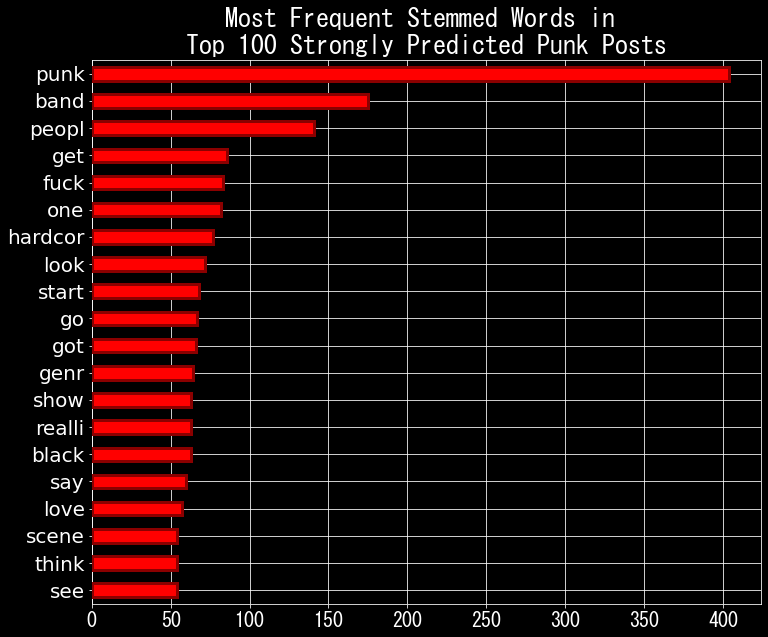

In [191]:
style.use('dark_background')
plt.figure(figsize=(12,10))
top_20_punk_preds.sort_values().plot(kind='barh',
                       color='red',
                       grid=True,
                       ec='darkred',
                       linewidth=3,
                       zorder=3 # Thanks Greg on SO: https://stackoverflow.com/questions/23357798/how-to-draw-grid-lines-behind-matplotlib-bar-graph
                    )
plt.title('Most Frequent Stemmed Words in \nTop 100 Strongly Predicted Punk Posts', 
          fontsize=26, 
          fontname='MS Gothic')
plt.xticks(fontsize=20, 
           fontname='MS Gothic')
plt.yticks(fontsize=20);

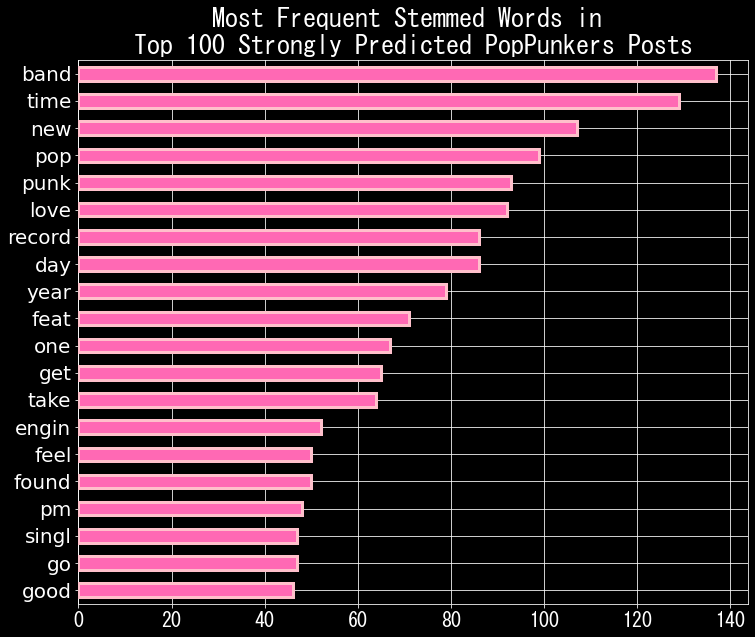

In [192]:
style.use('dark_background')
plt.figure(figsize=(12,10))
top_20_poppunk.sort_values().plot(kind='barh',
                    grid=True,
                    color='hotpink',
                    ec='pink',
                    linewidth=3,
                    zorder=3)
plt.title('Most Frequent Stemmed Words in \nTop 100 Strongly Predicted PopPunkers Posts', 
          fontsize=26, 
          fontname='MS Gothic')
plt.xticks(fontsize=20, 
           fontname='MS Gothic')
plt.yticks(fontsize=20);

We can't make any strong conclusions about the words here, but it is interesting to see that there aren't many band names in the top 20 for each category, except for *maybe* Black Flag in the Punk Subreddit. Something interesting to note is that **'new' and 'record'** pop up frequently in the posts that had the highest predictions of being in the PopPunkers subreddit. This could mean that the PopPunkers subreddit is more likely to create posts containing the words 'new' and 'record' than the Punk subreddit. 

### What tripped up our model?

Now let's look into the posts that tripped up our model and see if we can determine what words were used most often in those posts.

In [193]:
# Retrieving only the predictions we got wrong
predicted_wrong = predictions[predictions['predicted_subreddit'] != predictions['actual_subreddit']]

In [194]:
# Grabbing the original post text
wrong_orig_posts = predicted_wrong['orig_post']

In [195]:
top_20_wrong = top_20_words(wrong_orig_posts)

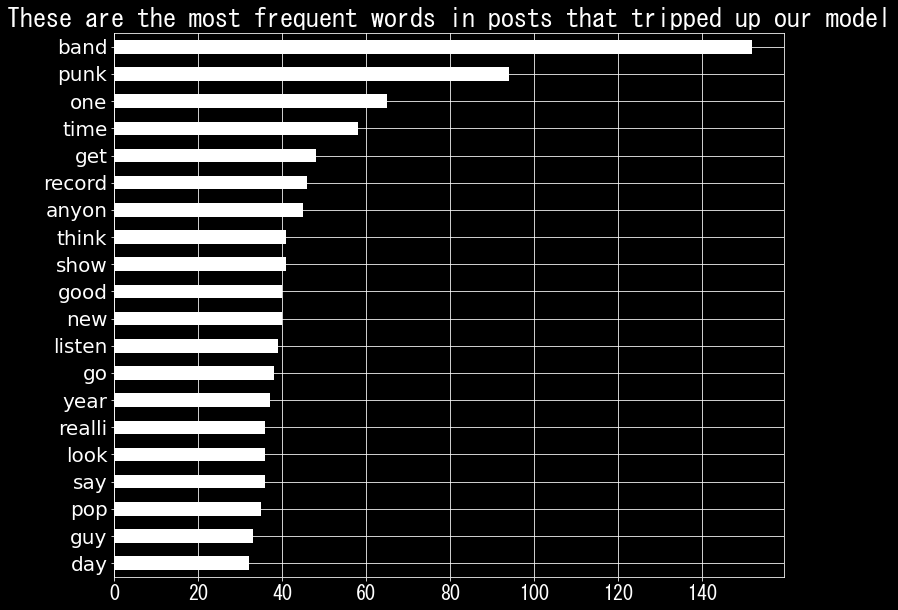

In [197]:
style.use('dark_background')
plt.figure(figsize=(12,10))
top_20_wrong.sort_values().plot(kind='barh', 
                       color='white',
                       grid=True,
                       linewidth=3,
                       zorder=3)
plt.title('These are the most frequent words in posts that tripped up our model', 
          fontsize=26, 
          fontname='MS Gothic')
plt.xticks(fontsize=20, 
           fontname='MS Gothic')
plt.yticks(fontsize=20);

Looking at this visual, it seems like there are quite a few words that intersect between the subreddits. Let's see what our model determined the predictive power of some of these words to be.

In [201]:
word_importance.loc[['band', 'punk', 'one', 'record', 'go', 'pop'], 'Coefficient']

band      0.014935
punk      0.028178
one       0.005978
record    0.002299
go        0.004801
pop       0.001637
Name: Coefficient, dtype: float64

The words "punk" and "band" seem to be determined by the model as important compared to other words, with 'punk' having about a **3% influence** on the eventual classification, and 'band' having about a **1% influence** on the classification.

## Final Conclusions

* The subreddits PopPunkers and Punk aren't completely separate groups, there is some overlap between them that trips up our Multinomial Naive Bayes model. Most notably, the words 'punk' and 'band' seem to be used regularly in both subreddits.
* The model outperforms the baseline model by ~30%, so this model could be useful for **marketing and messaging** purposes if further exploration and analysis is conducted on the **topics and words most commonly used** in each subreddit.

## Next Steps

* I'd like see how accurate the model was at predicting subreddits when the most important words are present.
 * I could reference posts containing each word and determine whether they were predicted correctly or not and store that in the `sorted_proba` dataframe
* Potentially removing words that seemed to trip up the model to improve accuracy rate